In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline



In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [4]:
def pred_target(df):
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df = df[df.price <= 1000]
    X = df[[x for x in df.columns if x not in ['price','bhk']]]
    y = df.price.values
    target = np.log(y)
    formula = "target ~ "+' + '.join(X)+' -1'
    y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
    y = y.values.ravel()
    return X, y
    

In [5]:
rome = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Rome_dfm.csv',
                   encoding='utf8')

In [6]:
X, y = pred_target(rome)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [8]:
X_train.shape, X_test.shape

((10909, 26), (4676, 26))

In [9]:
linmod = LinearRegression()

In [10]:
scores = cross_val_score(linmod, X_train, y_train, cv = 10)
print scores
print np.mean(scores)
print np.std(scores)

[ 0.52819012  0.53507957  0.51314335  0.47809942  0.50614848  0.51386876
  0.51463364  0.54054946  0.52518789  0.55253748]
0.520743816144
0.019641149637


In [11]:
predictions = cross_val_predict(linmod, X_test, y_test, cv = 10) 
accuracy = metrics.r2_score(y_test, predictions)
print accuracy


0.489916451957


In [12]:
residuals = y_test - predictions
residuals

array([-0.46029911,  0.04424622, -0.10241191, ..., -0.09406279,
       -0.36099309, -0.35536088])

In [13]:
np.mean(predictions)


4.5571779873795437

In [14]:
linmod.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
linmod.score(X_test, y_test)

0.49289423859768039

In [16]:
#linmod.coef_

In [17]:
print np.mean(y_train), np.mean(y_test)

4.56033425749 4.5571722742


In [18]:
# Regularization: Gridsearch an optimal ElasticNet regression

In [19]:
Xn = StandardScaler().fit_transform(X)

In [20]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

In [21]:
# enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1., 50), n_alphas=300, cv=10, verbose=1)
# enet_cv.fit(Xn_train, y_train)


In [22]:
# print enet_cv.l1_ratio_
# print enet_cv.alpha_

In [23]:
# enet = ElasticNet(alpha= enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)

# y_pred_enet = enet.fit(Xn_train, y_train).predict(Xn_test)
# r2_score_enet = metrics.r2_score(y_test, y_pred_enet)
# print(enet)
# print("r^2 on test data : %f" % r2_score_enet)


In [24]:
lassocv = LassoCV(n_alphas=300, cv=10)

In [25]:
lassocv.fit(Xn_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [26]:
lassocv.alpha_

0.0015477765187646366

In [27]:
lasso = Lasso(alpha=lassocv.alpha_)

y_pred_lasso = lasso.fit(Xn_train, y_train).predict(Xn_test)
r2_score_lasso = metrics.r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)


Lasso(alpha=0.0015477765187646366, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.529387


In [28]:
residuals = np.exp(y_test) - np.exp(y_pred_lasso)

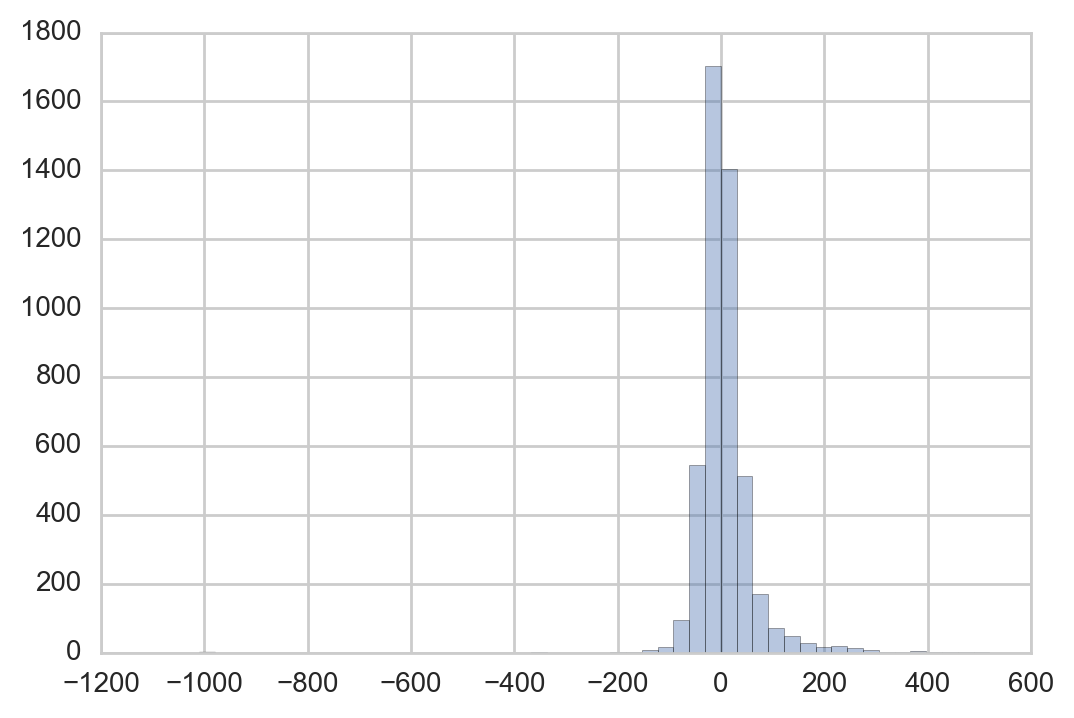

In [29]:
sns.distplot(residuals, bins=50, kde=False)

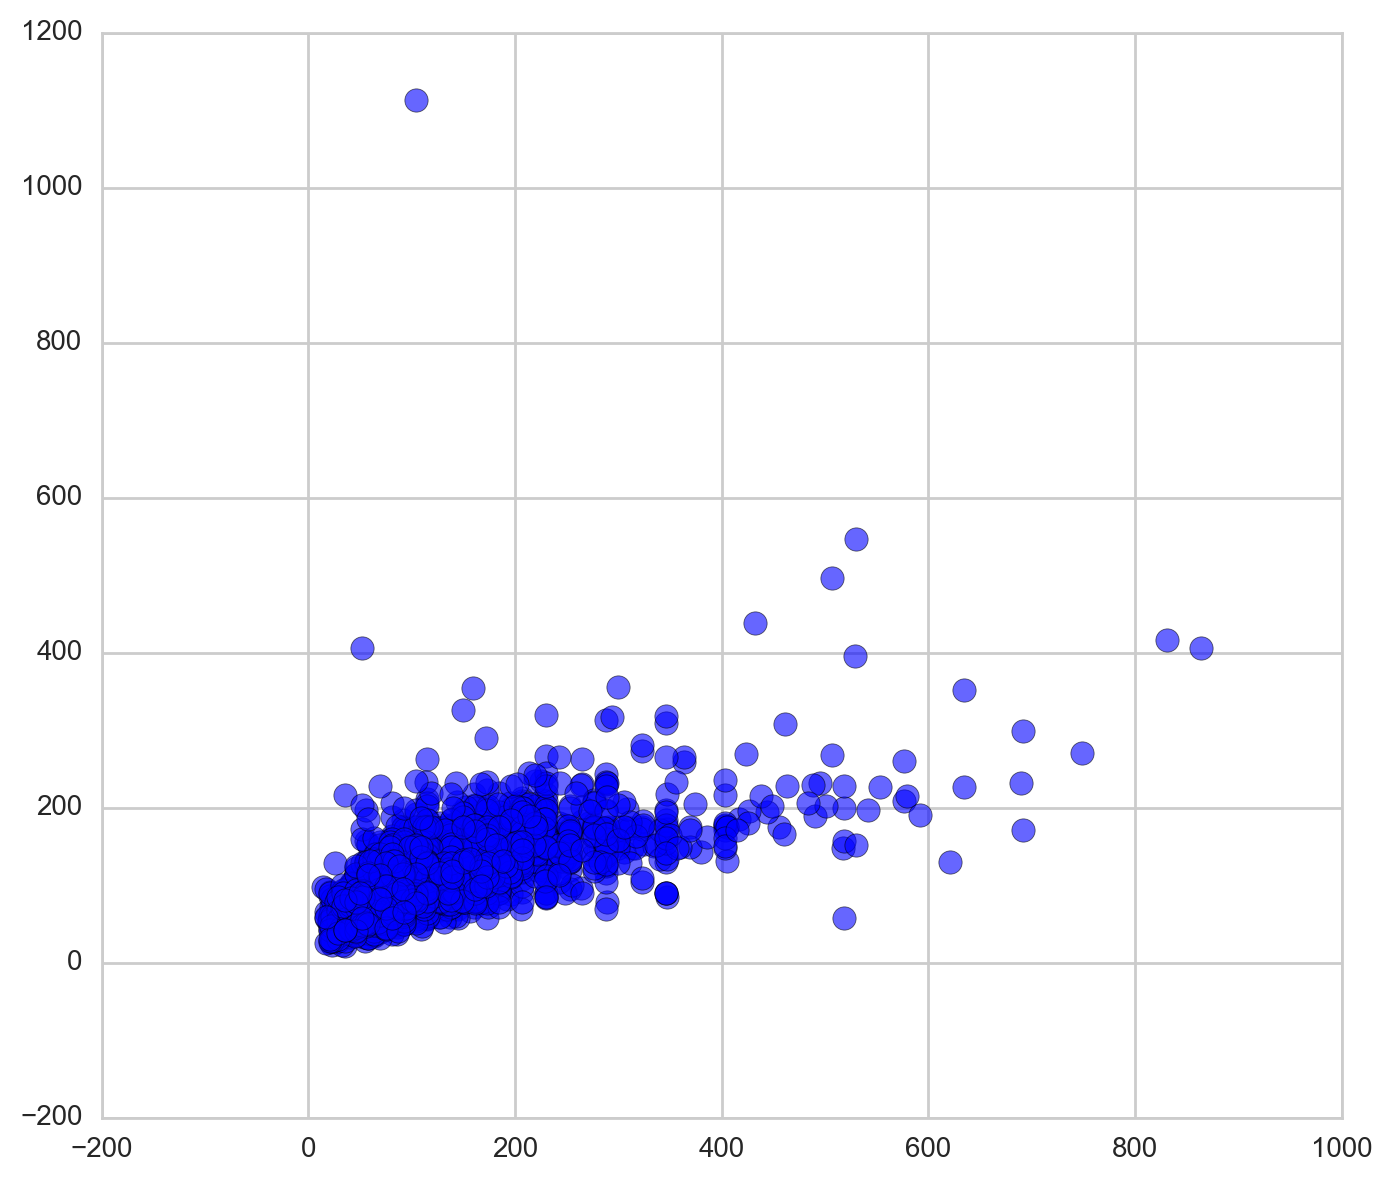

In [30]:
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(np.exp(y_test), np.exp(y_pred_lasso), s=70, alpha=0.6)
plt.show()

In [31]:
# Based on above plot, I will remove all prices that are higher than 1000/night.

In [32]:
lasso.fit(Xn_train, y_train)

lasso_coef = pd.DataFrame({
        'variable':X_train.columns,
        'coef':lasso.coef_,
        'abscoef':np.abs(lasso.coef_)
    })

lasso_coef.sort_values('abscoef', ascending=False, inplace=True)
lasso_coef[lasso_coef.coef != 0].head(25)


,abscoef,coef,variable
14,0.166389,-0.166389,room_type[T.Private room]
23,0.162444,0.162444,rest_count
17,0.116286,0.116286,bedrooms
16,0.090734,0.090734,bathrooms
15,0.071006,-0.071006,room_type[T.Shared room]
24,0.068665,-0.068665,reviews
22,0.059586,-0.059586,overall_satisfaction
10,0.049793,-0.049793,neighborhood[Municipio 5]
4,0.023158,0.023158,neighborhood[Municipio 13]
11,0.022060,-0.022060,neighborhood[Municipio 7]


In [33]:
# plt.plot(enet.coef_, color='lightgreen', linewidth=2,
#          label='Elastic net coefficients')
# plt.plot(lassocv.coef_, color='gold', linewidth=2,
#          label='Lasso coefficients')
# #plt.plot(linmod.coef_, '--', color='navy', label='original coefficients')
# plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
#           % (r2_score_lasso, r2_score_enet))
# plt.show()

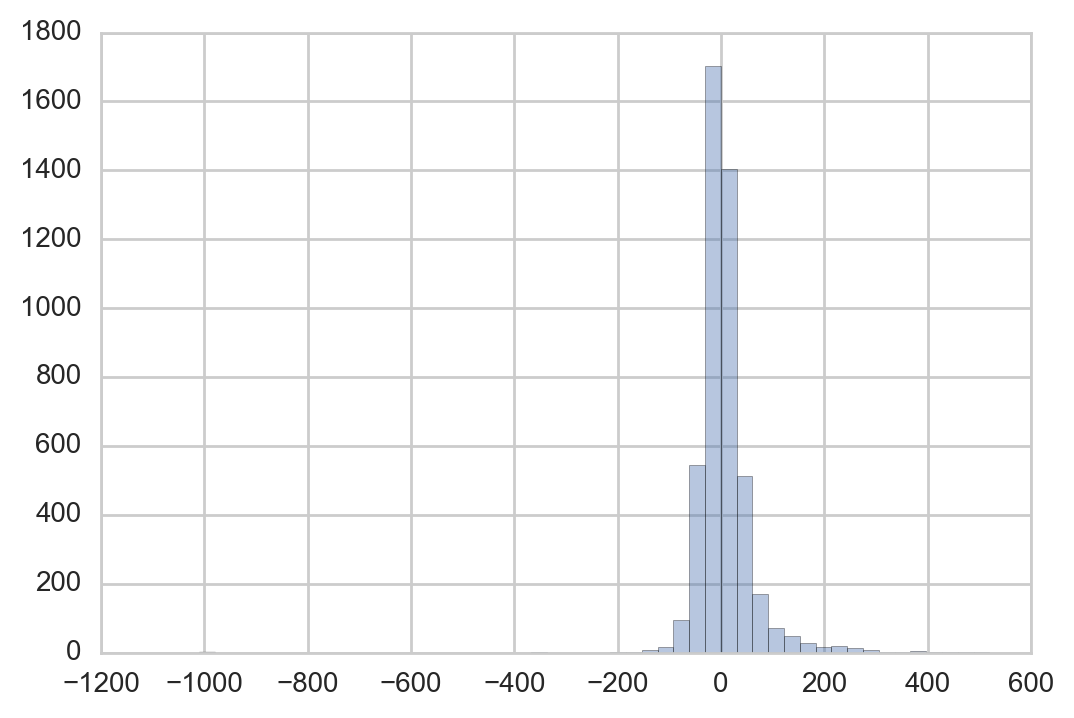

In [34]:
# plt.plot(residuals, '--', color='navy', label='original coefficients')
# plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
#           % (r2_score_lasso, r2_score_enet))
# plt.show()
sns.distplot(residuals, bins=50, kde=False)

In [35]:
lasso_coef = lasso_coef.reset_index(drop=True)


In [36]:
linmod.fit(Xn_train, y_train)

linmod_coef = pd.DataFrame({
        'variable':X_train.columns,
        'coef':linmod.coef_,
        'abscoef':np.abs(linmod.coef_)
    })

linmod_coef.sort_values('abscoef', ascending=False, inplace=True)
linmod_coef[linmod_coef.coef != 0].head(25)
linmod_coef = linmod_coef.reset_index(drop=True)

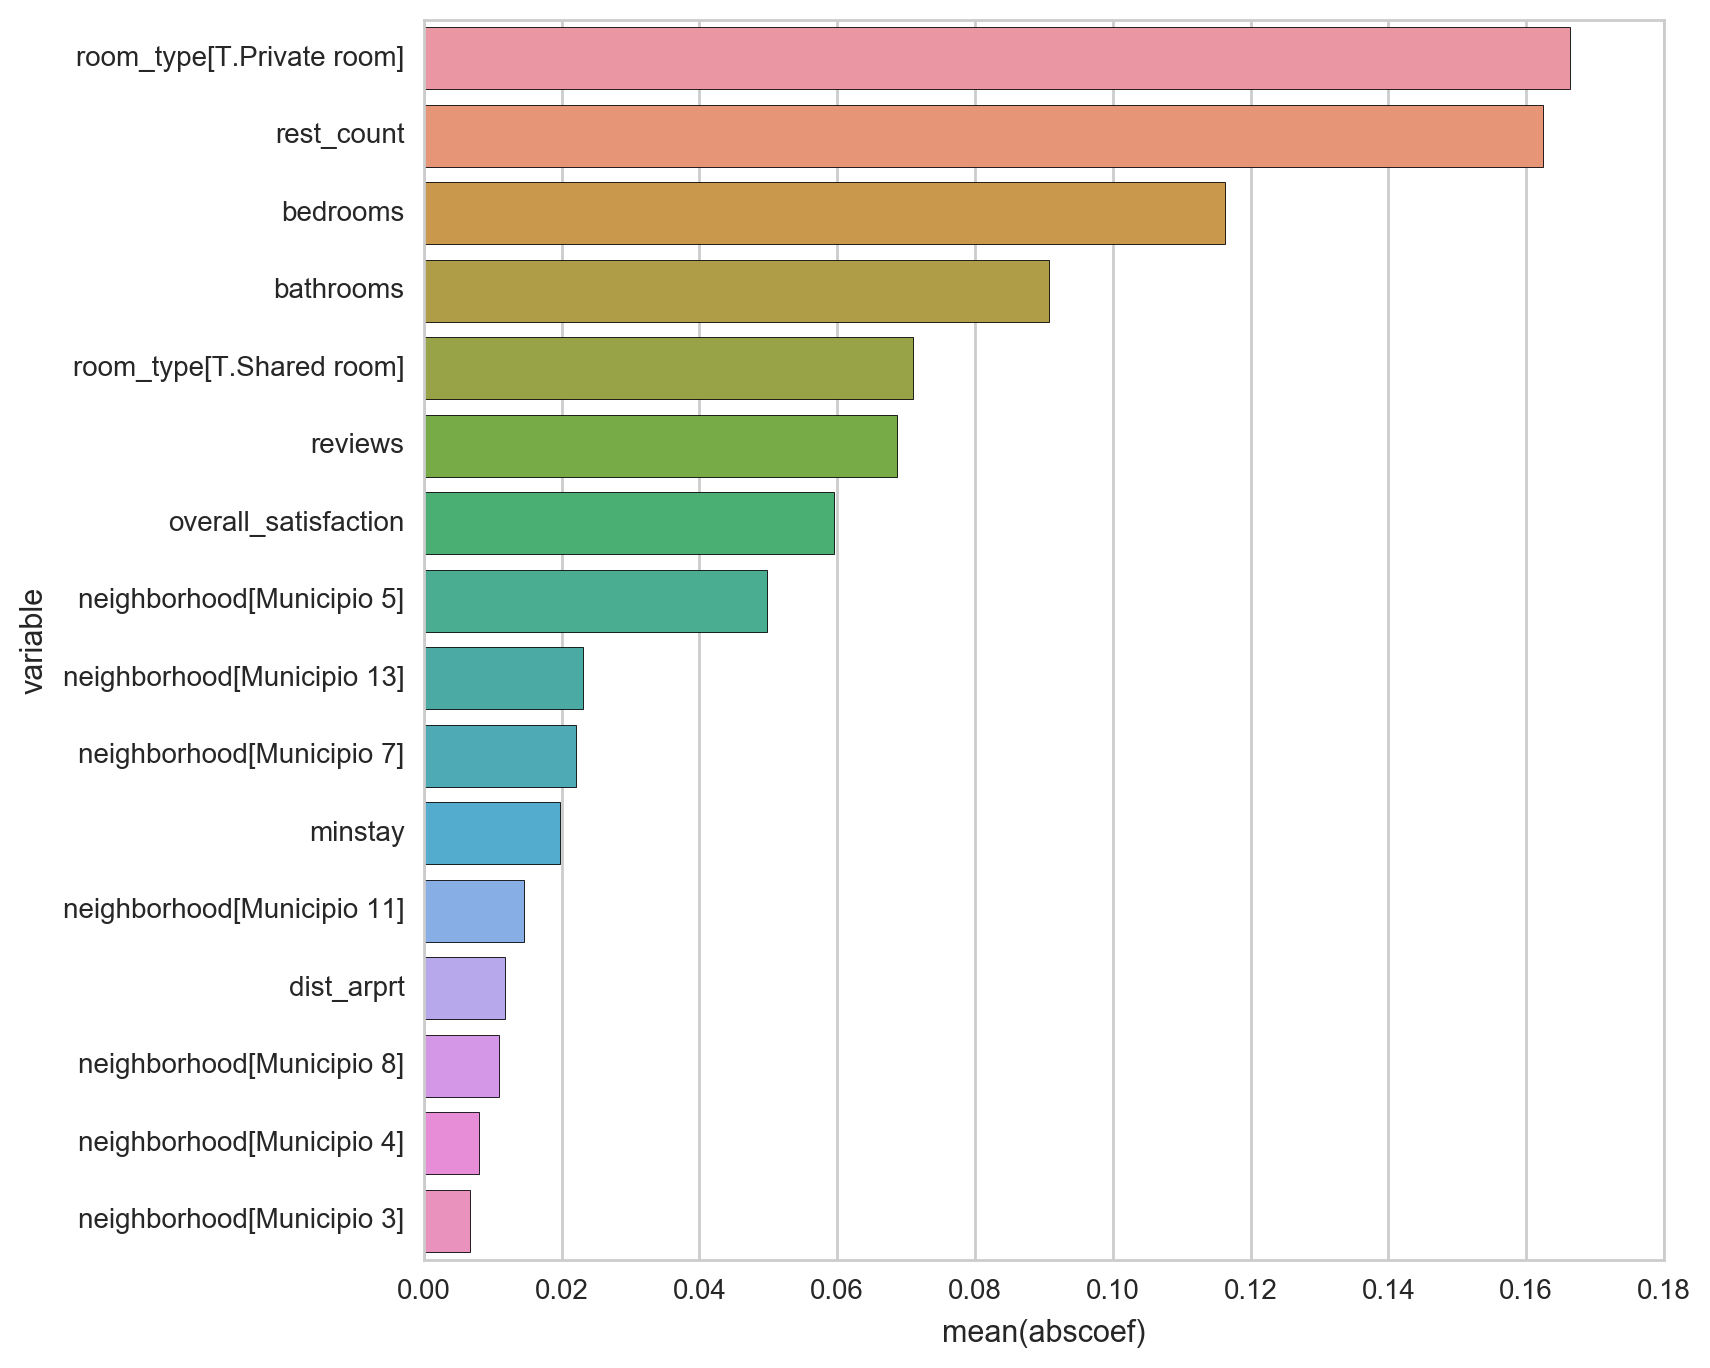

In [37]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = lasso_coef.loc[0:15,:].variable, x = lasso_coef.loc[0:15,:].abscoef, data=lasso_coef.loc[0:15,:],
            ax=ax
           )




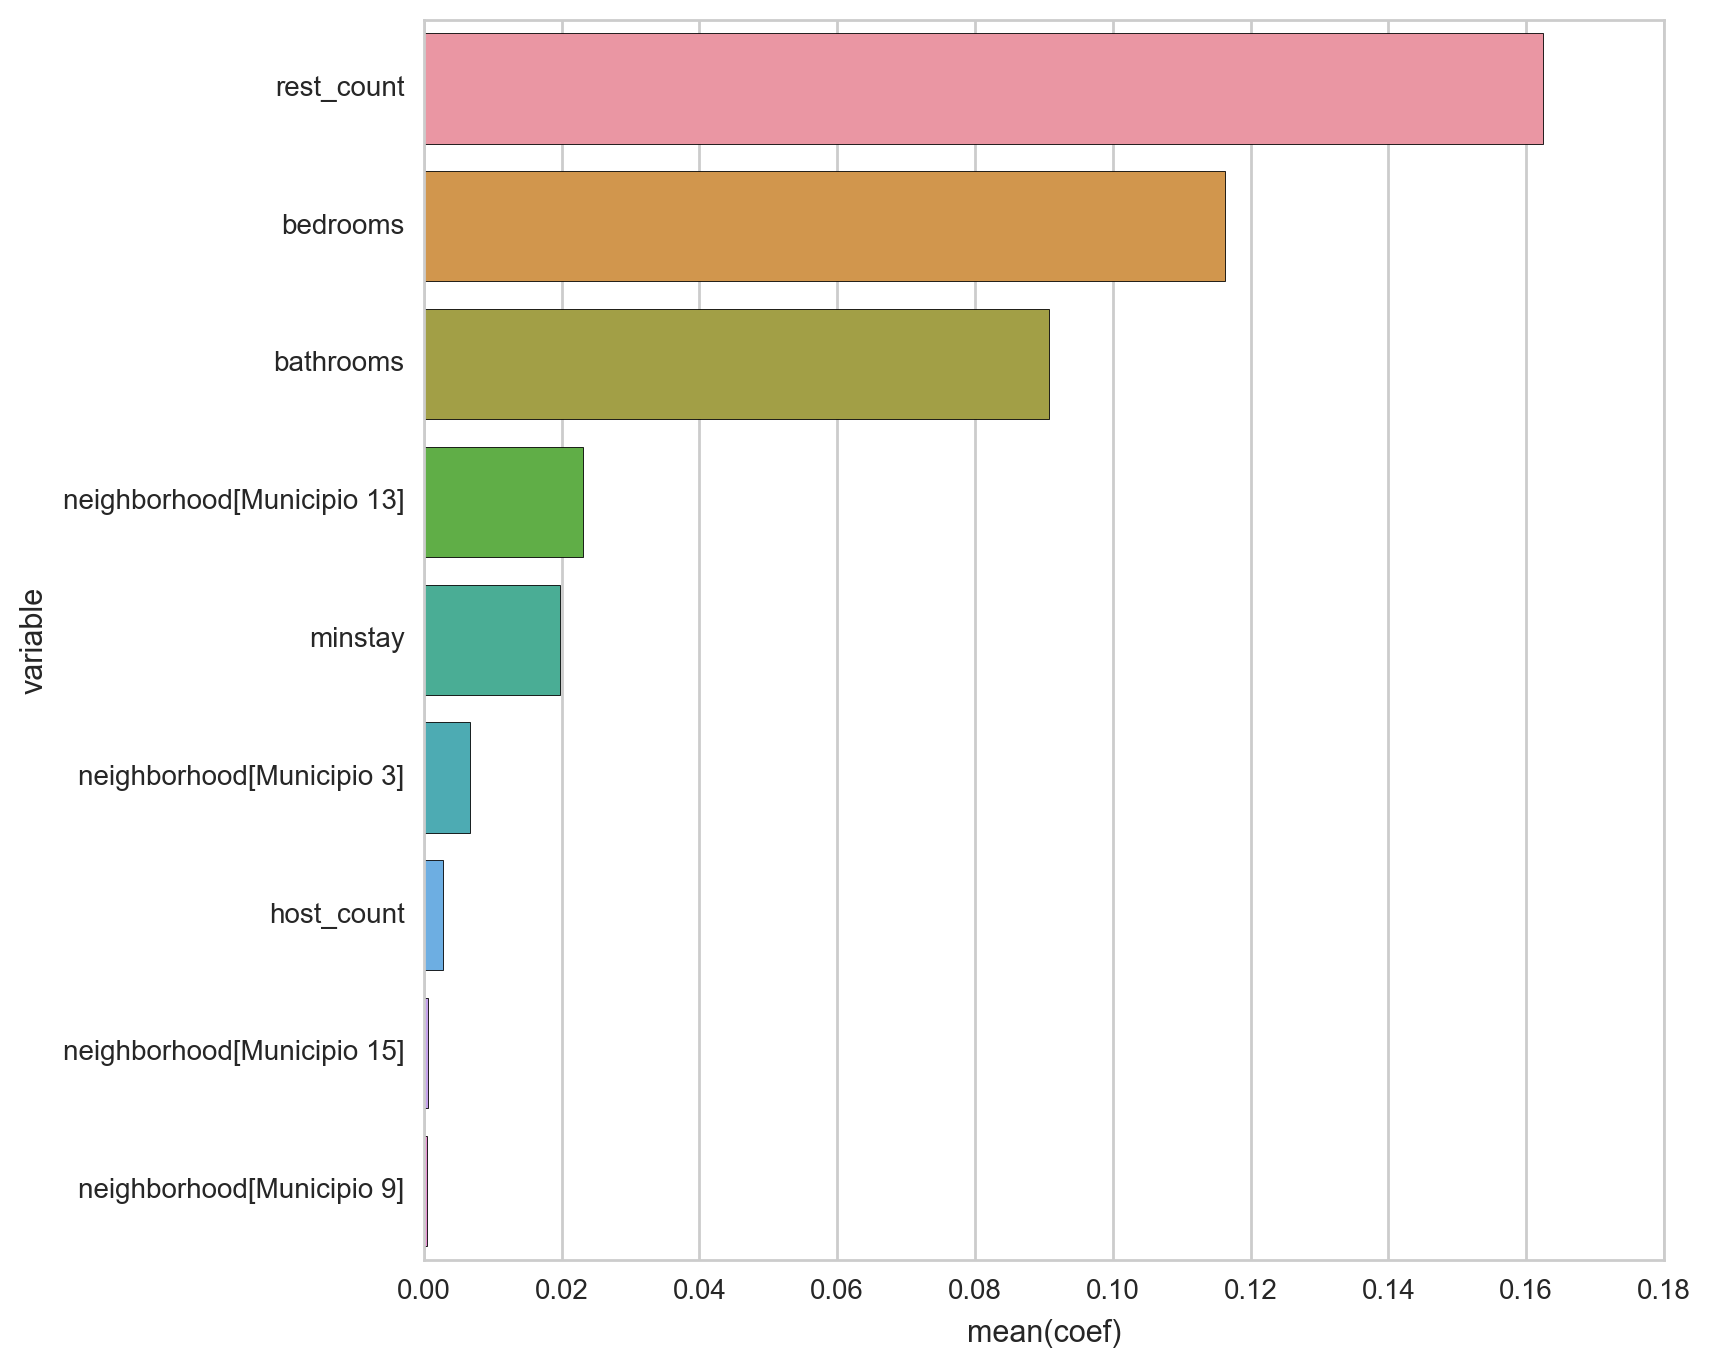

In [38]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = lasso_coef[lasso_coef.coef > 0].variable, x = lasso_coef[lasso_coef.coef > 0].coef, data=lasso_coef,
            ax=ax
           )
plt.show()

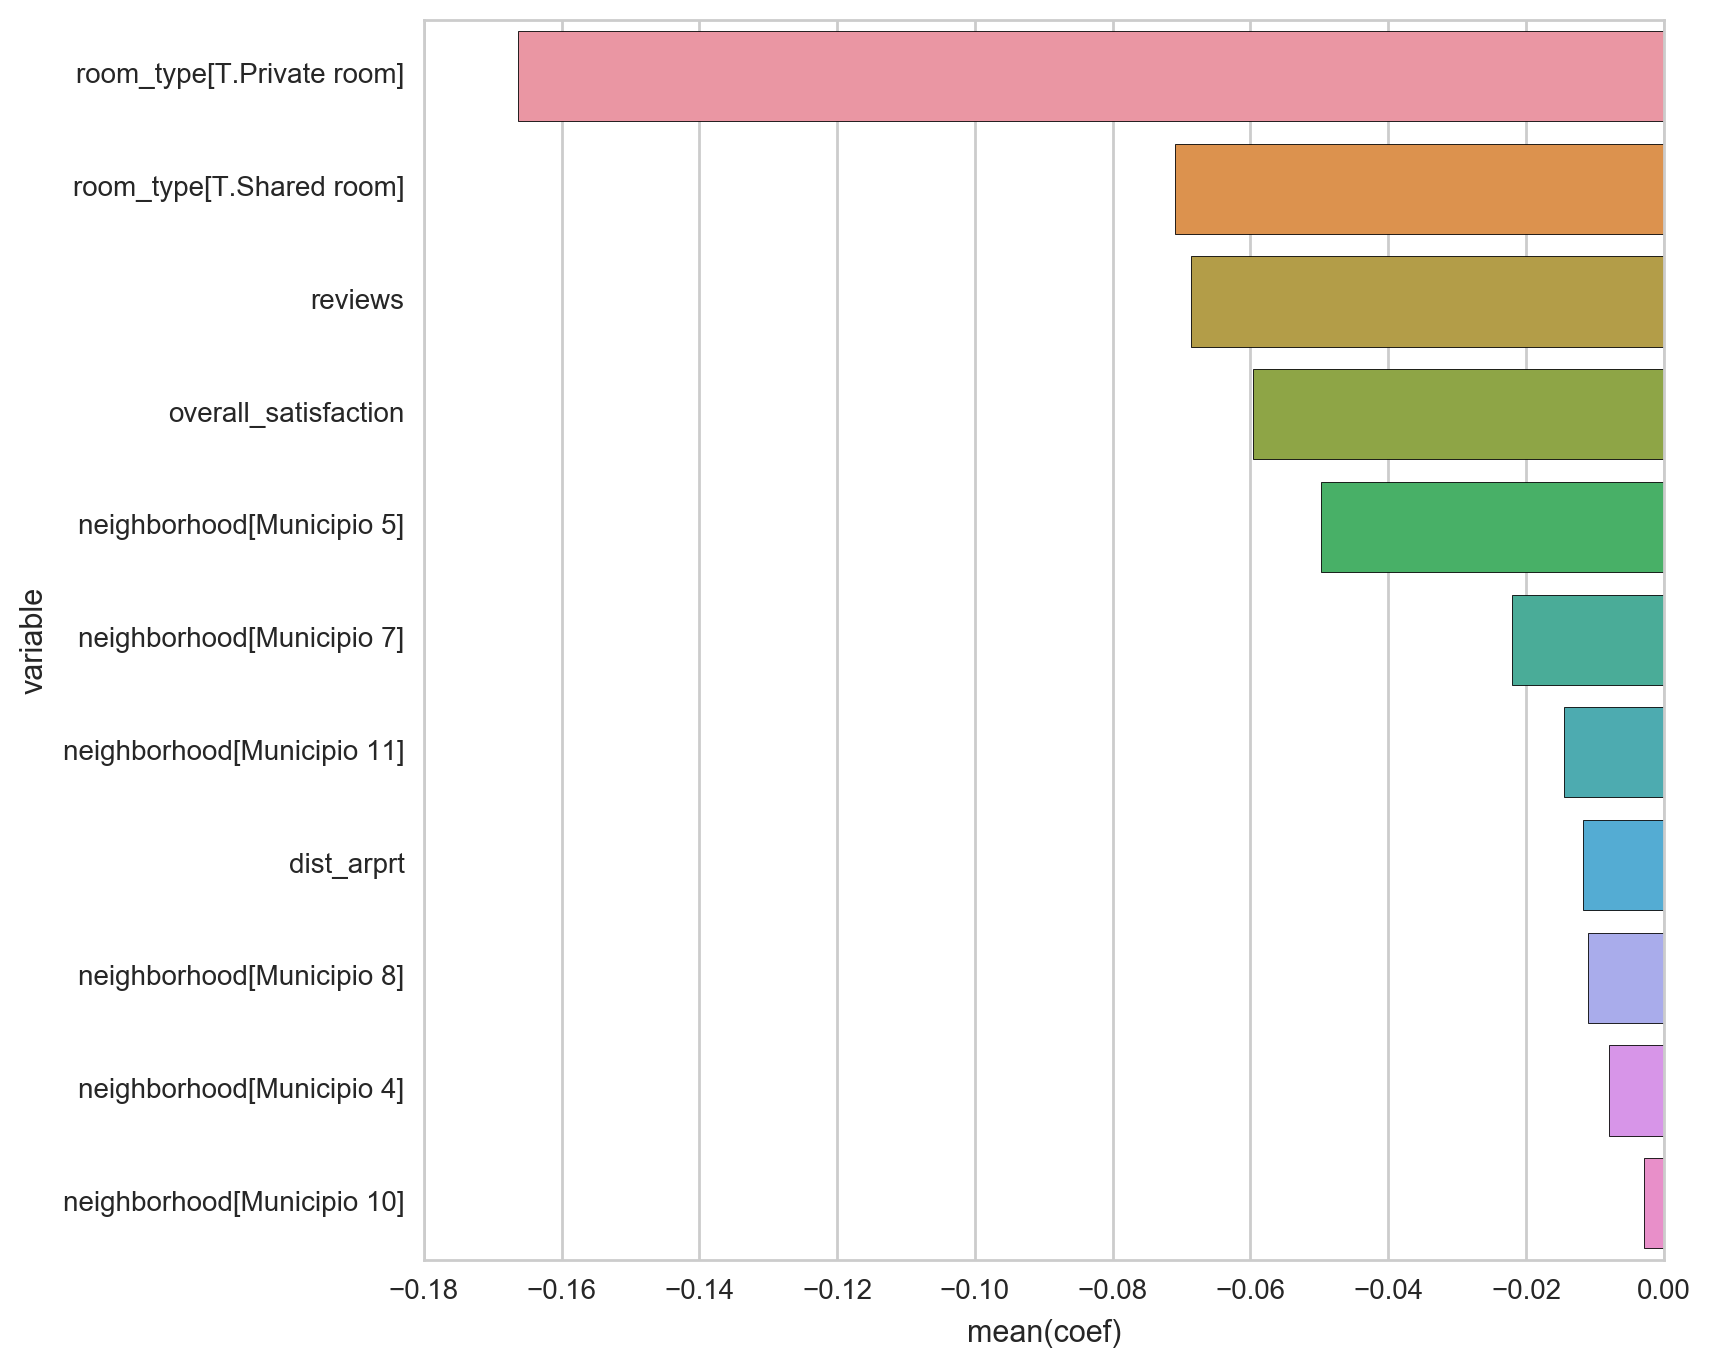

In [39]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = lasso_coef[lasso_coef.coef < 0].variable, x = lasso_coef[lasso_coef.coef < 0].coef, data=lasso_coef,
            ax=ax
           )
plt.show()